## Simulation of random graphs
MAP 572 CAO Ru X2017

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from numpy import linalg as LA
from sklearn.cluster import KMeans

In [131]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Q1.1 Simulate a graphe G

In [3]:
N = 7
 # with n <=2 case will be vertex2 connected to vertex1

def Generate_graphe(N):
    if N == 1:
        return np.array([[1]])
    if N == 2:
        return np.array([[1,1],[1,0]])
    
    G = np.array([[1,1],[1,0]])
    for i in range(2,N):
        proba = np.sum(G, axis = 0)/(2*i-1)
        proba_cum = np.cumsum(proba)
        #print(proba_cum)
        rand = np.random.rand()
        #print(proba_cum)
        for j in range(1,len(proba_cum)):
            #flag = True # flag = true means add a self edge
            if rand <= proba_cum[0]:
                vertex = 0
                break
            else:
                if rand > proba_cum[j-1] and rand <= proba_cum[j]:
                    vertex = j
                    break
            #print('vertex = ', vertex)
        new_G = np.zeros((i+1, i+1))
        new_G[:i,:i] = G
        new_G[i][vertex] = 1
        new_G[vertex][i] = 1
        G = new_G            

    return G


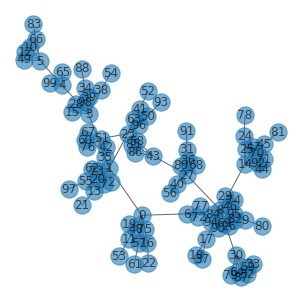

In [4]:
N_ = 100
G_ = Generate_graphe(N_)
Graphe_ = nx.from_numpy_matrix(G_) 
plt.figure(figsize=(4,4))
nx.draw(Graphe_, with_labels=True, alpha = 0.6, nodesize = 0.3)
plt.show()
#nx.draw(G,nodelist=NL,pos=position,node_color=ncolor,node_shape='>',node_size=nsize)

A graph can be represented by its adjacent matrix: Adjacence$(i,j) \in {0,1}$, where 1 means connected and 0 means not connected. For un-directed graph, the adjacent matrix will be symmetry. We now want to construct a graph in the way that the "popular vertex" are more likely to be selected when add new vertex to the graph, with probability:
$$
\mathbb{P}(v_{k+1} = i) = \frac{degree(i)}{\sum_{j}degree(j)} = \frac{degree(i)}{2k - 1}
$$

So the function takes the the number of final vertex $n$ as input. The implementation is done as follows:
* Create a numpy array $G$ of shape (n, n) are initialized to zero.
* Set G[0][0] to 1, which means 0 is connected to himself.
* When adding vertex $k$, we calculate the degree of all exsited vertex and normalized it to be a vector of $k$ dimension. 
* We simulate a random variable uniformly distributed in the interval [0,1], and add the vertex to the corresponding index of interval that the random variable belongs to. 
* Finally we show the graph with a python package named "networkx". 

An example of 100 points is shown above. We find that as a result of the construction algorithm, certain vertex are more likely to "attract" new vertex. And finally it turns out a cluster pattern. 

### Q1.2 Power-law

Let $s$ a vertex randomly selected from $G_n$:
$$\mathbb{P}(degree\quad of\quad s=k) \sim ck^{-\alpha}$$
We want to investigate its asympotic behavior when $n$ is large, and $k$ is small when compared to $n$.

There are two ways to do this question. 
The first is to simulate many times a graph of $n$ vertex, for each simulation:
* There are in total 2k-2 degrees(if we ignore the 1 connected from vertex 0 to vertex 0);
* so we save in a numpy array $count$ of dimmension $2k-2$ with each positon the number of vertex of that degree

Finally we average each $count$ element. 
This is show by the following:

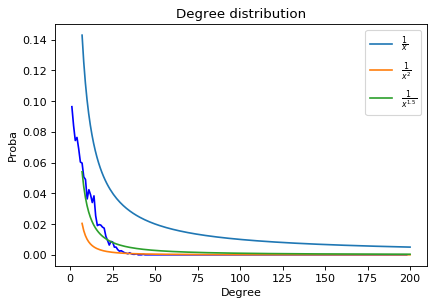

12 seconds used for generate graph with 100 vertex with 3000 times of simulation.


In [158]:
N = 100 # k max = N
n = 3000 # 100 fois de simulation

t1 = time.time()
s = 1 #round(np.random.rand()*50)
#print('s= ', s)
count = np.zeros(2*N-1)
for i in range(n):
    G = Generate_graphe(N)
    #print(G)
    d = int(np.sum(G, axis = 0)[s])
    count[d] += 1
count = count/np.sum(count)
t2 = time.time()

#print(count)
plt.figure(figsize=(6,4), dpi = 80)
plt.plot(np.arange(1,2*N-1), count[1:], 'b-')
plt.xlabel('Degree')
plt.ylabel('Proba')
plt.title('Degree distribution')

x = np.linspace(7, 200, 200)
plt.plot(x, 1./x, label = r'$\frac{1}{x}$')
plt.plot(x, 1./x**2, label = r'$\frac{1}{x^2}$')
plt.plot(x, 1./x**1.5, label = r'$\frac{1}{x^{1.5}}$')
plt.legend()

plt.show()
print(str(round(t2-t1)) +' seconds used for generate graph with '+str(N)+' vertex with '+str(n)+' times of simulation.')

To give a rought estimation of $\alpha$, $\frac{1}{x}, \frac{1}{x^2}, \frac{1}{x^{1.5}}$ has been added to the plot. We find that $\alpha$ is a value between 1 and 2, and maybe not far from $1.5$.

Maybe a more appropriate way is to transform this graph to log-scale.

In [213]:
N = 2000
G = Generate_graphe(N)
d = sorted(np.sum(G, axis = 0))

In [214]:
count = np.zeros(N)
for i in range(N):
    count[int(d[i])] += 1
#print(count)

In [216]:
for i in range(1,len(count)):
    if count[i] == 0:
        count = count[1:i]
        break
count = np.log(count)
degree = np.log(np.arange(1,len(count)+1))

Text(0.5, 1.0, 'Degree distribution')

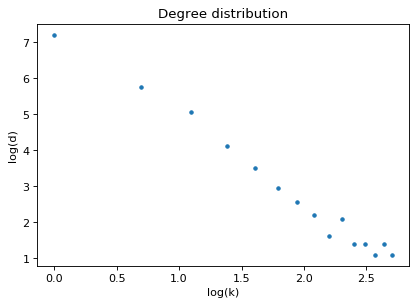

In [220]:
plt.figure(figsize=(6,4), dpi = 80)
plt.plot(degree, count, '.')
plt.xlabel('log(k)')
plt.ylabel('log(d)')
plt.title('Degree distribution')

So we see that there is a rough linear relation. And we find that $\alpha$ is around 2.5.

### Q1.3 
We want to explain why there is a "a rich-gets-richer phenomenon". 
For a given vertex, let's say vertex 1:
$$
    \mathbb{E}[X_{l+1}|X_{l}] = \frac{(X_l+1)\times X_l}{2l-1} + X_l\times(1-\frac{X_l}{2l-1}) = \frac{2l}{2l-1}
\times X_n$$

With $\mathbb{E}[X_{n+1}|X_{n}] = \frac{2n}{2n-1}X_l$:

$$
\begin{aligned}
\mathbb{E}[X_{n+1}] &= \mathbb{E}[\mathbb{E}[X_{n+1}|X_{n}]]\\
                    &= \mathbb{E}[\frac{2n}{2n-1}X_n]\\
                    &= \frac{2n}{2n-1}\mathbb{E}[X_n]
\end{aligned}
$$

Therefore:
$$
\mathbb{E}[X_{n+1}] = \frac{2n}{2n-1}\cdot\frac{2(n-1)}{2(n-1)-1}\cdots\frac{2}{1}\mathbb{E}[X_1] = \frac{(2n)!!}{(2n-1)!!}\mathbb{E}[X_1]
$$

while the average degree of the graph show be:
$$
\frac{2l-1}{l} = 2- \frac{1}{l}
$$
If we take $n = 100$, the begining point $E[X] =1$ will have in general $\frac{100!!}{99!} \sim 12$ degree, which is larger than 2. This explains to power law. 

## 2 Visualisatio of a graph

We will draw the graph by the following way:
* We simulated n random points $(X_i, Y_i)$ in the area $[0,1]^2$;
* If $i,j$ are connected in graph $G$, we draw a line beteween point $(X_i, Y_i), (X_j, Y_j)$

For $n = 100$, a such graph is shown as below:

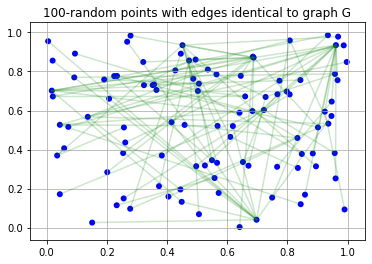

In [6]:
n = 100
G = Generate_graphe(n)

fig, ax = plt.subplots()

points = []
for i in range(n):
    x, y = np.random.rand(2)
    #print(x,y)
    points.append((x,y))
    ax.scatter(x, y, color = 'b', edgecolors='none')
for i in range(n):
    for j in range(i):
        if G[i][j] == 1:
            xtmp = [points[i][0], points[j][0]]
            ytmp = [points[i][1], points[j][1]]
            plt.plot(xtmp[0:2], ytmp[0:2],'g-', alpha = 0.2)
ax.grid(True)
plt.title(str(n)+'-random points with edges identical to graph G')

plt.show()
    

### Q2.2 Minimise engery

We could define the "energy" of the graph from the matrix of distance, where $D(i,j)$ refers to the least number of edge between vertex $i$ and $j$.
$$
E = \sum_{i,j} \frac{(\frac{1}{\sqrt{2}} \left\lVert M_i - M_j\right\rVert - D_{i,j}^*)^2}{(D_{i,j}^*)^2}
$$

where
$$
D_{i,j}^* = \frac{Distance(i,j)}{max_{i,j} Distance(i,j)}
$$

To obtain the distance matrix, there several possible ways:
* By using an algorithm of Dijkstra, which is of complexity $O(|V|+|E|)$ with $|V|$ number of vertex and $|E|$ number of edges to find the shortest path between one source point and all other points in the graph. In this case we need to implement $n$ times this algorithm because each implementation permet us to fill one row and one column in the distance matrix. So the total complexity would be $O(|V|^2+|E\cdot V|)$

* Construct the matrix while generating the graph. While adding vertex $k+1$: 
$$
\begin{aligned}
D[i][k+1] = 1  \quad & if G[k+1][i] = 1\\
D[i][k+1] = D[i][j] + 1 \quad & where D[j][k] = 1
\end{aligned}
$$

D is also a symetry matrix. 
This method is of the same complexity of construct the graph, thus is $O(n^2)$. But compare to the first way, it is more direct.
* We can also calculate the distance matrix by using the adjacency matrix $G$. The idea is that when making self product, the first time $k$ for a elment in the product matrix $G^k[i,j]$ is not zero is the distance between $i, j$, which is k.

#### Test the correctness of the generation of distance in a small graph:
To test the correctness, we take example of $N = 5$:

In [7]:
def Generate_graphe_with_distance(N, seed):
    np.random.seed(seed)
    if N == 1:
        return np.array([[1]])
    if N == 2:
        return np.array([[1,1],[1,0]])
    
    distance = np.zeros((N,N))
    distance[0][1], distance[1][0] = 1,1
    #print(distance)
    
    G = np.array([[1,1],[1,0]])
    for i in range(2,N):
        proba = np.sum(G, axis = 0)/(2*i-1)
        proba_cum = np.cumsum(proba)
        #print(proba_cum)
        rand = np.random.rand()
        #print(proba_cum)
        for j in range(1,len(proba_cum)):
            #flag = True # flag = true means add a self edge
            if rand <= proba_cum[0]:
                vertex = 0
                break
            else:
                if rand > proba_cum[j-1] and rand <= proba_cum[j]:
                    vertex = j
                    break
            #print('vertex = ', vertex)
      
        new_G = np.zeros((i+1, i+1))
        new_G[:i,:i] = G
        new_G[i][vertex] = 1
        new_G[vertex][i] = 1
        G = new_G
        
        #print('vertex = ', vertex)
        for j in range(i):
            if j == vertex:
                distance[i][j] = 1
                distance[j][i] = 1
            else:
                distance[i][j] = distance[vertex][j] + 1
                distance[j][i] = distance[vertex][j] + 1      

    return G, distance

The corresponding distance matrix:
 [[0. 1. 1. 1. 1.]
 [1. 0. 2. 2. 2.]
 [1. 2. 0. 2. 2.]
 [1. 2. 2. 0. 2.]
 [1. 2. 2. 2. 0.]]


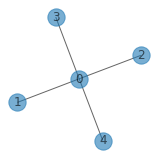

In [8]:
N = 5
G, distance = Generate_graphe_with_distance(N,2)
Graphe = nx.from_numpy_matrix(G) 
plt.figure(figsize = (2,2))
nx.draw(Graphe, with_labels=True, alpha = 0.6)
print('The corresponding distance matrix:\n', distance)

### Plot $G_n$ with $E$ minimized energy: gradian method

In the case of only one variable, $E^{n+1} = E^{n} - \alpha\times d E(x) $.

Key paremeters for gradient descent are:
* $\alpha$: length of step. Later we will fine-tuning this parameter, in the name of "fine-tuning learning rate".
* Directional derivative

With given form of engery function, which depends on the distance matrix and the geometrical coordinates of represented points at region $[0,1]^2$:

$$
\begin{aligned}
E &= \sum_{i,j} \frac{(\frac{1}{\sqrt{2}} \left\lVert M_i - M_j\right\rVert - D_{i,j}^*)^2}{(D_{i,j}^*)^2} \\
& = \sum_{i,j} \frac{(\frac{1}{\sqrt{2}} \sqrt{(x_i-x_j)^2 + (y_i-y_j)^2} - D_{i,j}^*)^2}{(D_{i,j}^*)^2}
\end{aligned}
$$

Therefore, $$
\begin{aligned}
\partial_{x_i} E = \sum_{(i,j)} 2\frac{(\frac{1}{\sqrt{2}} \sqrt{(x_i-x_j)^2 + (y_i-y_j)^2} - D_{i,j}^*)} {(D_{i,j}^*)^2} \times \frac{(x_i - x_j)}{\sqrt{2} \sqrt{(x_i-x_j)^2 + (y_i-y_j)^2})}
\end{aligned}
$$

$$
\begin{aligned}
\partial_{y_i} E = \sum_{(i,j)} 2\frac{(\frac{1}{\sqrt{2}} \sqrt{(x_i-x_j)^2 + (y_i-y_j)^2} - D_{i,j}^*)}{(D_{i,j}^*)^2} \times \frac{(y_i - y_j)}{\sqrt{2} \sqrt{(x_i-x_j)^2 + (y_i-y_j)^2})} 
\end{aligned}
$$

The descending scheme is as follows:
* Stop criterion: number of given iteration is reached.
* For each iteration: calculate the directional derivatives for each point; normalise the directional derivatives; move all the points accordingly with respect to selected appropriate $\alpha$ value.
After testing the gradient descent in various randomly generated graphs and look at the behavior of their energy as a function of iteration time, we could find that the $\alpha$ ("step length") is quiet important for the convergence. If we are approaching to a local minimum, and we have very small $\alpha$, it will be difficult to get out of this local area. Therefore I tested three difference "learning scheme": 
* learning rate is a step function, decreasing.
* learning rate is a cosine function.
* learning rate is a constance.

In [52]:
def Distance(i, j, points):
    x = (points[i][0] - points[j][0])**2
    y = (points[i][1] - points[j][1])**2
    return np.sqrt(x+y)

#def Detoile(D,i,j):
#    return D[i,j]/np.max(D)


def D_Energie(i, points, D): # derive of energy at point i.
    n = len(G)
    d_theory = D/np.max(D)
    sumX, sumY = 0,0
    for j in range(n):
        if j != i:
            detoile = d_theory[i][j]
            #print('detoile = ', detoile)
            dij = Distance(i, j, points)
            #print('dij = ', dij)
            sumX += (dij - np.sqrt(2)*detoile)*(points[i][0] - points[j][0])/(detoile**2 * dij)
            sumY += (dij - np.sqrt(2)*detoile)*(points[i][1] - points[j][1])/(detoile**2 * dij)
    #print('sumX, sumY = ', sumX, sumY)
    dx = sumX/np.sqrt((sumX**2 + sumY**2))
    dy = sumY/np.sqrt((sumX**2 + sumY**2))
    return np.array([dx, dy])

def Energie(D, points):
    n = len(points)
    E = 0
    d_theory = D/np.max(D)
    for i in range(n):
        for j in range(i-1):
            detoile = d_theory[i][j]
            #print('detoile = ', detoile)
            E += (1./np.sqrt(2)*Distance(i,j,points)- detoile)**2/(detoile**2)
    return 2*E
    
def Gradian_descent(T, points, D, mode):
    """
    T: number of iteration
    points: list of all coordinate
    D: distance matrix
    """
    n = len(points)
    lrs = []
    if mode == 'step':
        lr = [0.3, 0.2, 0.1, 0.05, 0.01] # learning rate
        for e in lr:
            lrs += [e]*int(n*T/len(lr))
    if mode == 'cosine':
        lrs = np.array([np.cos(i*20/(2*np.pi*T)) for i in range(T*n)])*0.2+0.2
    if mode == 'expcos':
        lrs = (np.array([np.cos(i*8/(2*np.pi*T)) for i in range(T*n)])*0.2+0.2)*np.exp(-0.001*np.arange[0,n*T])
    if mode == 'constance':
        lrs = np.array([0.01]*n*T)
    energy = Energie(D, points)
    E = []
    j = 0
    while j < T:
        #print('point before = \n', points[i][0], points[i][1])
        #i = np.random.randint(n) # the point to move
        for i in range(n):
            xi, yi = points[i][0], points[i][1]
            dxi, dyi = lrs[j*n+i] * D_Energie(i, points, D)
            xi, yi = xi - dxi, yi - dyi
            points[i] = (xi, yi)
            E.append(Energie(D, points))
        j += 1
        #print('j = ', j)

    plt.figure(figsize = (10,3), dpi = 80)
    plt.subplot(1,2,1)
    plt.plot(np.arange(len(E)), E, 'b-')
    plt.xlabel('iteration')
    plt.ylabel('Energy')
    plt.title('Energy with iterations with n = '+str(n))
    
    plt.subplot(1,2,2)
    plt.plot(np.arange(len(E)), lrs, 'g-')
    plt.xlabel('iteration')
    plt.ylabel('learning_rate')
    plt.title('lrs with iterations with n = '+str(n))
    
    #plt.savefig('./E_iteration_'+str(n), dpi=100)
    return points
        

Their performance are tested on the same graph with 100 points shown by nx below:

Show the graph by package networkx


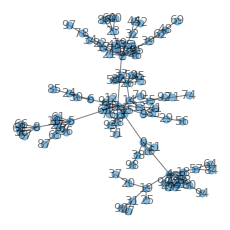

In [10]:
N = 100
seed = 815
G,D = Generate_graphe_with_distance(N,815)
Graphe = nx.from_numpy_matrix(G) 
plt.figure(figsize = (3,3))
print('Show the graph by package networkx')
nx.draw(Graphe, with_labels=True, alpha = 0.5, node_size = 50)


In [50]:
def generate_points(N, seed):
    np.random.seed(seed)
    n = N
    points = []
    for i in range(n):
        x, y = np.random.rand(2)
        points.append((x,y))
    return points

def plot_geometry(points, G, mode, start = 0):
    fig, ax = plt.subplots()

    for i in points:
        x, y = i[0], i[1]
        ax.scatter(x, y, color = 'b', edgecolors='none', alpha = 0.7)

    for i in range(N):
        for j in range(i):
            if G[i][j] == 1:
                xtmp = [points[i][0], points[j][0]]
                ytmp = [points[i][1], points[j][1]]
                plt.plot(xtmp[0:2], ytmp[0:2],'g-', alpha = 0.2)
                #plt.savefig('./E_iteration_points_fini_n ='+str(n), dpi=150)
    ax.grid(True)
    if start == 1:
        plt.title('position initial')
    else:
        plt.title('position after SD, mode ='+str(mode))
    plt.show()

We plot the energy as a function of number of iteration. At each iteration, we move only one vertex.
As shown below, we used 6 minutes to finish 10,000 iterations, with energy about 8,000 at last.

time used for GD : 360


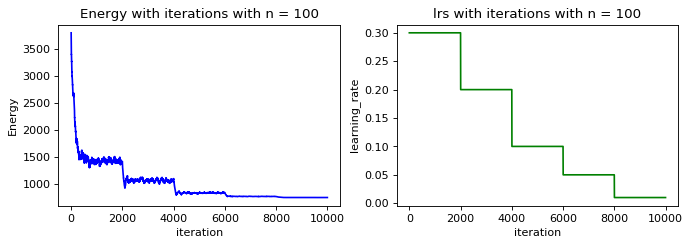

In [12]:
points = generate_points(N, seed)

points_origin = points.copy()

time1 = time.time()
gd_points = Gradian_descent(100, points, D, 'step')
time2 = time.time()
print('time used for GD :', round(time2 - time1))

We will look at in the geometrical space, the points of vertex before and after the gradient descent.

The initial random coordinate is shown as follows:

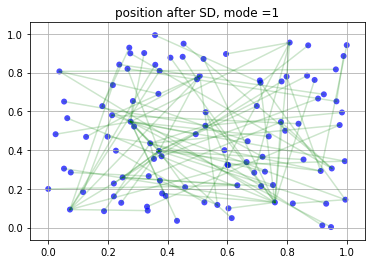

In [13]:
plot_geometry(points_origin, G, 1)

After gradient descent, we see clearly the cluster of the graph: 

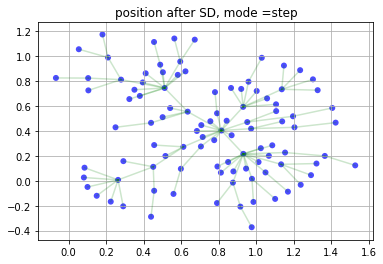

In [14]:
plot_geometry(gd_points, G, 'step' )

Similarly, we present the results for cosine learning rate scheme:

time used for GD of cosine lr : 330


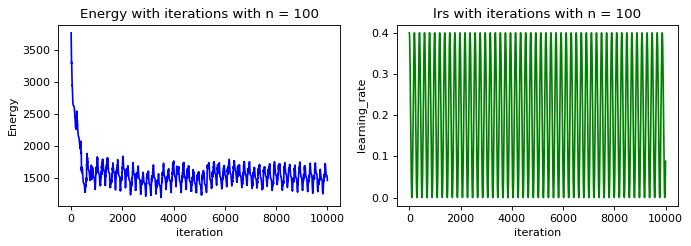

In [15]:
points = generate_points(N, seed)

points_origin = points.copy()

time1 = time.time()
gd_points = Gradian_descent(100, points, D, 'cosine')
time2 = time.time()
print('time used for GD of cosine lr :', round(time2 - time1))

And the positions after 10,000 iteration of gradient descent:

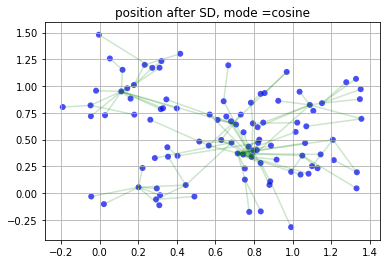

In [16]:
plot_geometry(gd_points, G, 'cosine' )

time used for GD of constant lr : 325


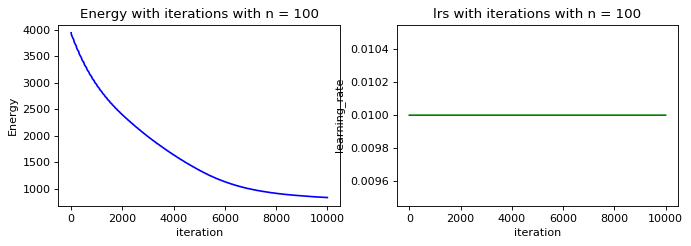

In [17]:
points = generate_points(N, seed)

points_origin = points.copy()

time1 = time.time()
gd_points = Gradian_descent(100, points, D, 'constance')
time2 = time.time()
print('time used for GD of constant lr :', round(time2 - time1))

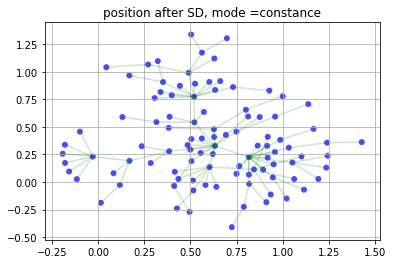

In [18]:
plot_geometry(gd_points, G, 'constance' )

We remark that the cosine learning rate is not ideal, and this confirmes that near the end of the iteration, we should adapt small learning rates. Otherwise, the energy function will just oscillate around a near by local minimum. In this case, we got $E = 1500$. 

Both step learning rates and constance learning rate give acceptable perfomance. And clearly, the step learning rate scheme converges much faster at the beginning, then for each given $\alpha$, it stugs in a certain value unless we go to smaller $\alpha$. This inlight us to accelerate the converging process by using smaller iterations at each learning rate value.(1/5 of that of constance mode for instance.)

We find that with 2000 iterations, we are proching to the minimum that is reached by using a constant learning rate in 10,000 iterations.

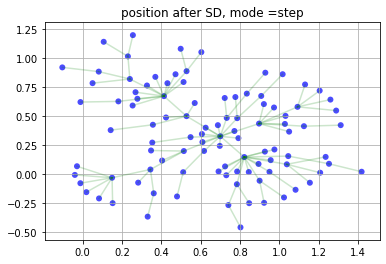

In [21]:
plot_geometry(gd_points, G, 'step')

So it is verifed that with step learning rate, we could have a faster convergence rate with better performance. 

### Summary of Gradient descent
#####  Major difficulty encontered
I have spent many times in the part of Gradient descent because it did not give the expected optimazation. I began with stochastic gradient descent, which means every time I will just pick up one point and move this point. At the end of even 10,000 iterations, the performance were still limited. 

I finally found that it was mainly because of a main constrain that I added in gradient descent: If the updated position of a point is out of range $[0,1]^2$, then we disregard this movement. So we find that with this constrain, it takes longer time to do the simulation, because we will have many times of useless calculs.

* lr is a constant for all iterations, which is the most simple way.
* lr is a decreasing step function with regards to iterations. Intuitively, at the beginning moving with a large scale help to find a relatively good position rather quickly and then we can fine-tuning that with smaller steps
* lr is a extreched cosine function with regards to iteration. The cosine anealing is a function always used in deep learning model. With the periodical pattern, we repeat the above decrease step function, but still leave a change to get out of the local minimum, sinc the energy is not a convex function.

##### Small techniques for gradient descent
One small techniques that I find useful for the gradient descent is:
* Normalize the directional derivatives. This goes with the fact that we pre-assigned learning rate value. Given the fact the region is $[0,1]^2$, if the gradient is far more larger than 1, then even with small $\alpha$, that will go far away from this area and takes time to get it back. So I normalize the directional derivatives such that $dx^2 + dy^2 = 1$. According, the learning rate assigned will ranging from 0.01 to 0.3. 

## Monte-Carlo Markov Chain method
Before implementing the suggested gradient descent method, I first tried to use a MCMC method:
* Vertex in the graph are possible permutations of all geometrical points. 
* We start from a random state and we explore it's numbers. (cf TP6 for detail of the algorithm). 

We give a example of using this algorithm a graph with 200 vertex:

In [22]:
def Distance(i,j,points):
    x = (points[i][0] - points[j][0])**2
    y = (points[i][1] - points[j][1])**2
    return np.sqrt(x+y)

def Detoile(D, i, j):
    return D[i,j]/np.max(D)

def Echangeij(G, D, points, i, j):
    #il faut d'abord changer le matrix D
    #print('G n of edge', np.sum(np.sum(G, axis = 0)))
    # change i et j:
    tmpi = D[i,:].copy()
    tmpi[i], tmpi[j] = tmpi[j], tmpi[i]
    
    tmpj = D[j,:].copy()
    tmpj[i], tmpj[j] = tmpj[j], tmpj[i]
    
    #print('i,j = ', i,j)
    #print('D before change:\n', D)
    
    D[i,:] = tmpj
    D[:,i] = tmpj.T
    D[j,:] = tmpi
    D[:,j] = tmpi.T
    #print('D after change:\n', D)
    
    tmpi = G[i,:].copy()
    tmpi[i], tmpi[j] = tmpi[j], tmpi[i]
    
    tmpj = G[j,:].copy()
    tmpj[i], tmpj[j] = tmpj[j], tmpj[i]
    
    G[i,:] = tmpj
    G[:,i] = tmpj.T
    G[j,:] = tmpi
    G[:,j] = tmpi.T
    
    return G, D, points

def Energie(D, points):
    n = len(points)
    E = 0
    for i in range(n):
        for j in range(i):
            detoile = Detoile(D, i, j)
            E += (1./np.sqrt(2)*Distance(i,j,points)- detoile)**2/(detoile**2)
    return E

def MCMC(G, D, points, beta, T):
    n = len(points)
    Es = []
    for i in range(T):
        i, j = np.random.randint(n), np.random.randint(n)
        #print('i,j = ', i, j)
        E_0 = Energie(D, points)
        # Echange ij, if not finalelment, echange j i to return to initial state
        G, D, points = Echangeij(G, D, points, i, j)
        E_1 = Energie(D, points)
        if E_1 < E_0:
            #print('E1, E0 = ', E_1, E_0)
            Es.append(E_1)
        else:
            if np.random.rand() < np.exp(-beta*(E_1 - E_0)):
                Es.append(E_1)
            else:
                G, D, points = Echangeij(G, D, points, i, j)
                Es.append(E_0)
                
    plt.figure(figsize = (6,4), dpi = 70)
    plt.plot(np.arange(len(Es)), Es, 'g-')
    plt.xlabel('iteration')
    plt.ylabel('E')
    plt.title('Energy in using MCMC with iterations with n = '+str(n))
    return G, D, points

time used for MCMC : 411


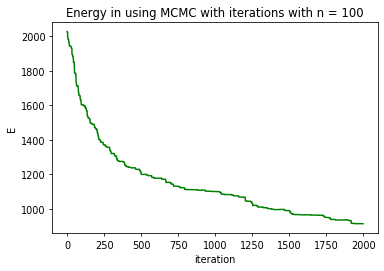

In [23]:
time1 = time.time()
graphe, matrix_distance, points = MCMC(G, D, points_origin, 2, 2000)
time2 = time.time()
print('time used for MCMC :', round(time2 - time1))

No handles with labels found to put in legend.


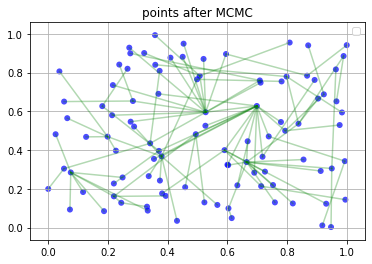

In [24]:
fig, ax = plt.subplots()

for i in points:
    x, y = i[0], i[1]
    ax.scatter(x, y, color = 'b', edgecolors='none', alpha = 0.7)
    
for i in range(n):
    for j in range(i):
        if graphe[i][j] == 1:
            xtmp = [points[i][0], points[j][0]]
            ytmp = [points[i][1], points[j][1]]
            plt.plot(xtmp[0:2], ytmp[0:2],'g-', alpha = 0.3)
ax.legend()
ax.grid(True)
plt.title('points after MCMC')

plt.show()

It is find that this takes longer time to find the local minimum. And since we don't change the position of vertex in this method, it is not ideal for minimized the energy.

Then I wonder whether the MCMC method will give better performance if I generate the inital points by $r$ and $\theta$(so in a circle) ? So I tested with the same graph but the original coordinate are "round":

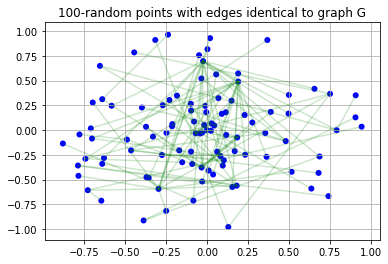

In [25]:
def points_circle(N, seed):
    np.random.seed(seed)
    fig, ax = plt.subplots()
    points = []
    for i in range(n):
        r = np.random.rand()
        theta = np.random.rand()*4*np.pi
        x, y = r*np.cos(theta), r*np.sin(theta)
        #print(x,y)
        points.append((x,y))
        ax.scatter(x, y, color = 'b', edgecolors='none')
    for i in range(n):
        for j in range(i):
            if G[i][j] == 1:
                xtmp = [points[i][0], points[j][0]]
                ytmp = [points[i][1], points[j][1]]
                plt.plot(xtmp[0:2], ytmp[0:2],'g-', alpha = 0.2)
    ax.grid(True)
    plt.title(str(n)+'-random points with edges identical to graph G')
    plt.show()
    return points

N = 100
seed = 815
points = points_circle(N, seed)

time used for MCMC : 422


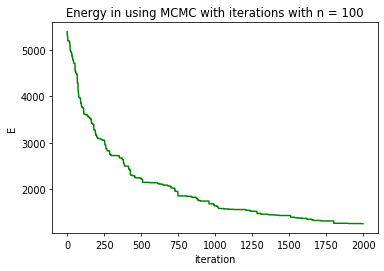

In [26]:
time1 = time.time()
graphe, matrix_distance, points = MCMC(G, D, points, 2, 2000)
time2 = time.time()
print('time used for MCMC :', round(time2 - time1))

Well, it indeed "looks" better:

No handles with labels found to put in legend.


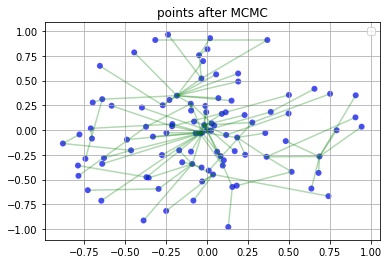

In [27]:
fig, ax = plt.subplots()

for i in points:
    x, y = i[0], i[1]
    ax.scatter(x, y, color = 'b', edgecolors='none', alpha = 0.7)
    
for i in range(n):
    for j in range(i):
        if graphe[i][j] == 1:
            xtmp = [points[i][0], points[j][0]]
            ytmp = [points[i][1], points[j][1]]
            plt.plot(xtmp[0:2], ytmp[0:2],'g-', alpha = 0.3)
ax.legend()
ax.grid(True)
plt.title('points after MCMC')

plt.show()

### Summary for MCMC method:
As we can see, if we randomly generate the points such that they distribute between a circle with radius 1, it turns out to be more satisfying than points randomly distributed in a square. This yields that to minimize energy, we have to have the most symetry possible, so that will be a circle. 

The MCMC method work not bad for small scale graphs ($n \leq 50$). And as we can see, the convergence rate is not terrible. For $n = 200$, after about 2000 iteration(permutation of points), it actually get close to the result that we calculated by gradient descent.

 But considering that the calculation of energy at each iteration is relatively time consuming. Finally we don't converge faster by the code that I implemented. However, there are two heuristic points that I would like to mention:

* With optimation of energy calculation, MCMC can be faster. We don't calculate the energy from scratch but only find the difference. 
* We can do a combination of MCMC method and gradient descent. If we are not sure about how to fine-tuning the learning rate, we can just try to relabel all vertex by MCMC, than we implement gradien descent.

### The $\delta$-preferential attachement

On peut généraliser le modèle du graphe à attachement préféfrentiel de la façon suivante. Soit $\delta \leq -1$ un paramètre fixé, on remplace l'équation(*) par:

$$
\mathbb{P}(v_{k+1} = i) = \frac{degré(i) + \delta}{\sum_j(degre(j) + \delta)} = \frac{degre(i) + \delta}{2k-1+k\delta}
$$

We will use the same algorithm with different $\delta$ values:

In [5]:
def Generate_graphe_delta(N, delta, seed):
    np.random.seed(seed)
    if N == 1:
        return np.array([[1]])
    if N == 2:
        return np.array([[1,1],[1,0]])
    
    G = np.array([[1,1],[1,0]])
    for i in range(2,N):
        proba = (np.sum(G, axis = 0)+delta)/(2*i-1 + i*delta)
        proba_cum = np.cumsum(proba)
        #print(proba_cum)
        rand = np.random.rand()
        #print(proba_cum)
        for j in range(1,len(proba_cum)):
            #flag = True # flag = true means add a self edge
            if rand <= proba_cum[0]:
                vertex = 0
                break
            else:
                if rand > proba_cum[j-1] and rand <= proba_cum[j]:
                    vertex = j
                    break
            #print('vertex = ', vertex)
        new_G = np.zeros((i+1, i+1))
        new_G[:i,:i] = G
        new_G[i][vertex] = 1
        new_G[vertex][i] = 1
        G = new_G            

    return G

Preferential attachement with $\delta$ = -0.9


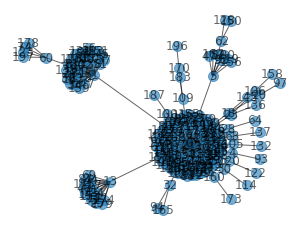

In [29]:
N = 200
seed = 815
delta = -0.9
G = Generate_graphe_delta(N, delta, seed)
plt.figure(figsize = (4,3))
Graphe = nx.from_numpy_matrix(G) 
print(r'Preferential attachement with $\delta$ = '+str(delta))
nx.draw(Graphe, with_labels=True, alpha = 0.6, node_size = 100)

Preferential attachement with $\delta$ = -0.5


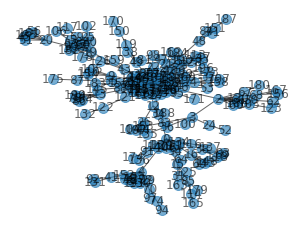

In [30]:
delta = -0.5
G = Generate_graphe_delta(N, delta, seed)
Graphe = nx.from_numpy_matrix(G) 
print(r'Preferential attachement with $\delta$ = '+str(delta))
plt.figure(figsize = (4,3))
nx.draw(Graphe, with_labels=True, alpha = 0.6, node_size = 100)

Preferential attachement with $\delta$ = 1


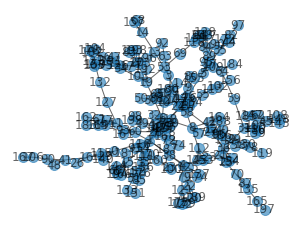

In [31]:
delta = 1
G = Generate_graphe_delta(N, delta, seed)
Graphe = nx.from_numpy_matrix(G) 
print(r'Preferential attachement with $\delta$ = '+str(delta))
plt.figure(figsize = (4,3))
nx.draw(Graphe, with_labels=True, alpha = 0.6, node_size = 100)

Preferential attachement with $\delta$ = 100


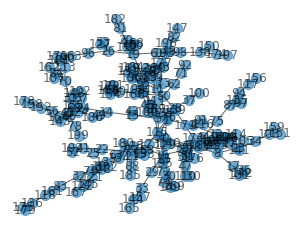

In [32]:
delta = 100
G = Generate_graphe_delta(N, delta, seed)
Graphe = nx.from_numpy_matrix(G) 
print(r'Preferential attachement with $\delta$ = '+str(delta))
plt.figure(figsize = (4,3))
nx.draw(Graphe, with_labels=True, alpha = 0.6, node_size = 100)

We observe that larger $\delta$ is , less possible for the graph to form large clusters. We can see this also from the formula:
* When $\delta >> k$, $\mathbb{P}(v_{k+1} = i) \sim \frac{1}{k}$, which means the equal probability for each existed vertex to be chosen. 
* When $\delta \to -1$, those vertex with only one degree has very small chance to be selected.

##  3 Clustering et detect de community by spectral decomposition

### Q3.1 & Q3.2 Implement unnormalized spectral clustering and test in graphs

Unnormalized spectral clustering
Input: Similarity matrix S ∈ Rn×n, number k of clusters to construct.
* Construct a similarity graph by one of the ways described in Section 2.
Let W be its weighted adjacency matrix.
* Compute the unnormalized Laplacian L.
* Compute the first k eigenvectors u1, . . . , uk of L.
* Let U ∈ Rn×k be the matrix containing the vectors u1 , . . . , uk as columns.
* For i = 1,...,n, let yi ∈ Rk be the vector corresponding to the i-th row of U.
* Cluster the points (yi)i=1,...,n in Rk with the k-means algorithm into clusters C1,...,Ck.
Output: Clusters A1,...,Ak with Ai = {j| yj ∈ Ci}.

In [6]:
def Distance(i,j,points):
    x = (points[i][0] - points[j][0])**2
    y = (points[i][1] - points[j][1])**2
    return np.sqrt(x+y)

# with the inverse of geometrical distance:
def sim_matrix(points):
    n = len(points)
    sim = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            #dij = Distance(i,j,points)
            dij = Distance(i,j, points)
            sim[i,j] = 1./dij
            sim[j,i] = 1./dij
    return sim
    
# with k-nearest neighbors:
def k_sim_matrix(points, k):
    n = len(points)
    sim = (D>k)*1
    return sim
        
    
def exp_sim_matrix(points, sigma):
    n = len(points)
    sim = np.zeros((n,n))
    for i in range(n):
        for j in range(i-1):
            x1, x2, y1, y2 = points[i][0], points[i][1], points[j][0], points[j][1]
            d = -((x1-x2)**2 + (y1-y2)**2)/(2*sigma**2)
            sim[i][j] = d
            sim[j][i] = d
    return np.exp(sim)
    

We take the graph studied in the gradient descent with the "step" learning rate. We know the adjacent matrix of this graph(same from the beginning), and we take the geometrical coordinate calculated by the precendent question.

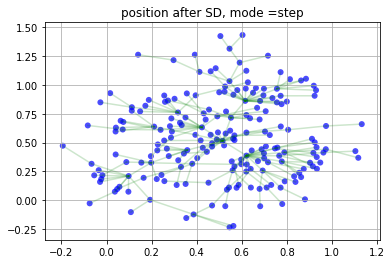

In [35]:
plot_geometry(gd_points, G, 'step')

In [100]:
def Spectual_kmeans(k, G):
    n = len(gd_points)
    diag = np.sum(G, axis = 0)
    Diag = np.eye(n)
    for i in range(n):
        Diag[i,i] = diag[i]
    L = Diag - G # the laplacian
    lambdas, uk = LA.eig(L)
    # we remark that in the uk, the eigenvector est representated by columns, i.e. u0 = uk[:,0]

    # find the k eigenvecteurs corresponds to k minimum eigenvalues:
    lambdas_sorted = sorted(lambdas)

    select = []
    for i in lambdas_sorted:
        if len(select) < k:
            if i> 0:
                select.append(i)
        else:
            break

    # select the corresponding eigenvalues:
    eigv = []
    for i in range(n):
        if lambdas[i] in select:
            eigv.append(uk[:,i])
    eigv = np.array(eigv).T

    #We select the first $k$ eigenvectors with largest eigenvalues.

    U = eigv #uk[:, -k:]
    Y = []
    for i in range(n):
        Y.append(U[i,:]) # get y_i

    centers = {}
    group = np.array([np.random.randint(0,n)%k for i in range(n)])
    #print(group)
    for i in range(k):
        tmp = np.random.rand()*n
        centers[i] = [Y[i][j] for j in range(k)] # the points are in R^k
    #print(centers) # random initial centers

    def Dist_k(i, C, Y): 
        # Y of format [y1, y2, ...] where y1 = (x1, x2, x3,..., xk)
        # C represente the coordinate of the centers
        k = len(Y[0])
        s = 0
        for e in range(k):
            s += (Y[i][e]-C[e])**2
        return np.sqrt(s)

    def update(k):
        groups = []
        for i in range(k):
            groups.append([])
        for i in range(n):
            groups[int(group[i])].append(Y[i])
        for i in range(k):
            tmp = np.array(groups[i])
            if len(tmp) != 0:
                X = []
                for ii in range(k):
                    X.append(tmp[:,ii].mean())
                centers[i] = X

    Y_tmp = np.copy(Y)
    #print(Y_tmp[:3])

    group_tmp = np.copy(group)
    for i in range(n):
        dist = float('inf')
        for kk in range(k):
            t_d = Dist_k(i, centers[kk], Y)
            if dist > t_d :
                dist = t_d
                group[i] = kk
                update(k)


    while np.sum(abs(group - group_tmp)) != 0:
        #record the group of point i
        group_tmp = np.copy(group)
        for i in range(n):
            dist = float('inf')
            for kk in range(k):
                t_d = Dist_k(i, centers[kk], Y)
                if dist > t_d :
                    dist = t_d
                    group[i] = kk
                    update(k)


    return group

In [102]:
def plot_spectual_geometry_kmeans(gd_points, group_spec, group_geo):
    plt.figure(figsize = (16,5), dpi=60)
    n = len(group_spec)
    #colorbar = {0:}
    plt.subplot(1,2,1)
    for i in range(n):
        x = gd_points[i][0]
        y = gd_points[i][1]
        if group_spec[i] == 0:
            plt.scatter(x, y, color = 'orange', alpha=0.8)
        if group_spec[i] == 1:
            plt.scatter(x, y, color = 'b', alpha=0.8)
        if group_spec[i] == 2:
            plt.scatter(x, y, color = 'g', alpha=0.8)
        if group_spec[i] == 3:
            plt.scatter(x, y, color = 'r', alpha=0.8)
        if group_spec[i] == 4:
            plt.scatter(x, y, color = 'purple', alpha=0.8)
        if group_spec[i] == 5:
            plt.scatter(x, y, color = 'm', alpha=0.8)

    for i in range(n):
        for j in range(i):
            if G[i][j] == 1:
                xtmp = [gd_points[i][0], gd_points[j][0]]
                ytmp = [gd_points[i][1], gd_points[j][1]]
                plt.plot(xtmp[0:2], ytmp[0:2],'g-', alpha = 0.03)
                #plt.savefig('./Spectural_k='+str(k), dpi = 100)

    plt.title('Spectrale clustering with k ='+str(k) + ', similarity matrix = k-near-neighbors')
    
    plt.subplot(1,2,2)
    for i in range(n):
        x = gd_points[i][0]
        y = gd_points[i][1]
        if group_geo[i] == 0:
            plt.scatter(x, y, color = 'orange', alpha=0.8)
        if group_geo[i] == 1:
            plt.scatter(x, y, color = 'b', alpha=0.8)
        if group_geo[i] == 2:
            plt.scatter(x, y, color = 'g', alpha=0.8)
        if group_geo[i] == 3:
            plt.scatter(x, y, color = 'r', alpha=0.8)
        if group_geo[i] == 4:
            plt.scatter(x, y, color = 'purple', alpha=0.8)
        if group_geo[i] == 5:
            plt.scatter(x, y, color = 'm', alpha=0.8)

    for i in range(n):
        for j in range(i):
            if G[i][j] == 1:
                xtmp = [gd_points[i][0], gd_points[j][0]]
                ytmp = [gd_points[i][1], gd_points[j][1]]
                plt.plot(xtmp[0:2], ytmp[0:2],'g-', alpha = 0.03)
                #plt.savefig('./Spectural_k='+str(k), dpi = 100)

    plt.title('Geomortry clustering with k ='+str(k) + ', similarity matrix = k-near-neighbors')


Then we implement the above spectral clustering method, and compare this result with the geometrical kmeans method by using the default python package. $k = 3,4$ are tested and show below, with spectral clustering at left and geometrical kmeans at right. 

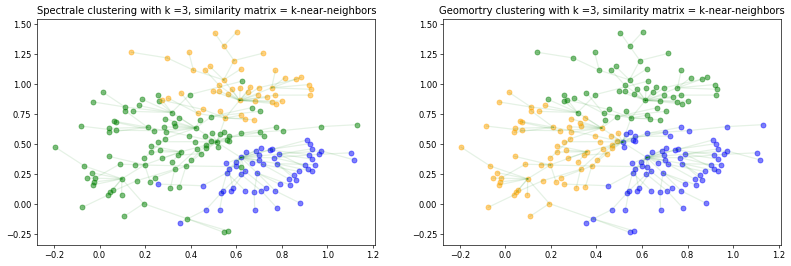

In [42]:
k = 3
group_spec = Spectual_kmeans(k, G)
X = gd_points.copy()
group_geo = KMeans(n_clusters = k, random_state=0).fit_predict(X)
plot_spectual_geometry_kmeans(gd_points, group_spec, group_geo)

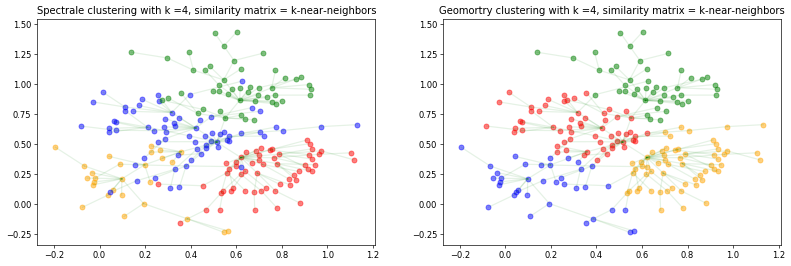

In [43]:
k = 4
group_spec = Spectual_kmeans(k, G)
X = gd_points.copy()
group_geo = KMeans(n_clusters = k, random_state=0).fit_predict(X)
plot_spectual_geometry_kmeans(gd_points, group_spec, group_geo)

### Q3.2 & Q3.3 
Above clustering results of Spectual clustering and geometrical clustering show that :
* Geometrical kmeans clustering depends only on the coordinates of each points.
* While, spectual sclustering depends mainly the structual of the graph. (Indeed, no geometrical information is used in Sepectual clustering). In the representation above, we find that after the gradient descent, some vertex belongs to different bruch but have close sptial position. By geometrical kmeans, they are close, while they are far from each other with respect to the "graph distance".

We also remark that we can pre-assign $k$ for the clustering. So k is a parameter to be fine-tuning in real clustering problem.

In [7]:
MatriceAdjacence=np.loadtxt('StochasticBlockModel.txt')

### Test the clustering in a stochastic block model.

We take the adjacency matrix of the graph given at moodle. To run this model, we need to obtain the distance matrix from the adjacency matrix. We use the folloing Floyd–Warshall algorithm:

The idea is for each point, iterate every other points to see whether there will be a shorter path. 

In [38]:
def dist_matrix(A):
    # return the distance matrix from the adjacency matrix
    n = len(A)
    D = A.copy()
    for i in range(n):
        D[i][i] = 0
    for i in range(n):
        for j in range(i+1):
            if D[i][j] == 0:
                D[i][j] = np.inf
                D[j][i] = np.inf
    print('D after initialisation = \n', D)
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                if D[i][j] > D[i][k] + D[k][i]:
                    D[i][j] = D[i][k] + D[k][j]
                    D[j][i] = D[i][j]
    print('D after algo = \n', D)
    for i in range(n):
        D[i][i] = 0
        for j in range(n):
            if D[i][j] == np.inf:
                D[i][j] = 0
                D[j][i] = 0
    print('D after return = \n', D)
    return D
    

We get the distance matrix as follows:

In [43]:
D

array([[0., 2., 2., ..., 2., 2., 2.],
       [2., 0., 2., ..., 2., 2., 2.],
       [2., 2., 0., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 0., 2., 2.],
       [2., 2., 2., ..., 2., 0., 2.],
       [2., 2., 2., ..., 2., 2., 0.]])

We also show this graph by susing networkx package, which give us an idea about what it will look like:

Show the graph by package networkx


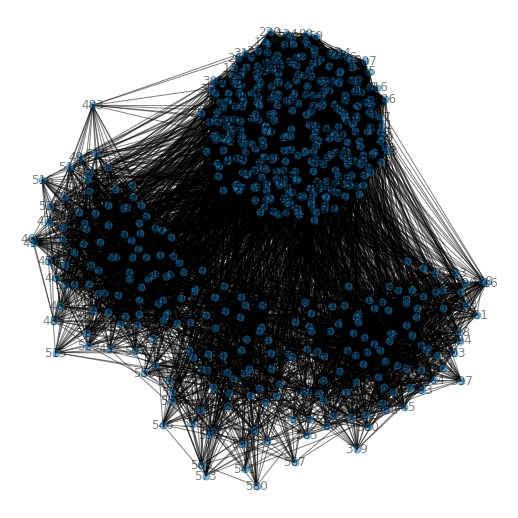

In [48]:
N = 600
seed = 815
#G,D = Generate_graphe_with_distance(N,815)
G = MatriceAdjacence.copy()
Graphe = nx.from_numpy_matrix(G) 
plt.figure(figsize = (7,7))
print('Show the graph by package networkx')
nx.draw(Graphe, with_labels=True, alpha = 0.5, node_size = 50)

In [79]:
def Gradian_descent(T, points, D, mode):
    """
    T: number of iteration
    points: list of all coordinate
    D: distance matrix
    """
    n = len(points)
    print('n = ', n)
    lrs = []
    if mode == 'step':
        lr = [0.3, 0.2, 0.1, 0.05, 0.01] # learning rate
        for e in lr:
            lrs += [e]*int(n*T/len(lr))
    if mode == 'cosine':
        lrs = np.array([np.cos(i*20/(2*np.pi*T)) for i in range(T*n)])*0.2+0.2
    if mode == 'expcos':
        lrs = (np.array([np.cos(i*8/(2*np.pi*T)) for i in range(T*n)])*0.2+0.2)*np.exp(-0.001*np.arange[0,n*T])
    if mode == 'constance':
        lrs = np.array([0.01]*n*T)
    energy = Energie(D, points)
    E = []
    j = 0
    while j < T:
        #print('point before = \n', points[i][0], points[i][1])
        #i = np.random.randint(n) # the point to move
        for i in range(n):
            xi, yi = points[i][0], points[i][1]
            dxi, dyi = lrs[j*n+i] * D_Energie(i, points, D)
            #print('points : ', dxi, dyi)
            xi, yi = xi - dxi, yi - dyi
            points[i] = (xi, yi)
            E.append(Energie(D, points))
            #print('E[-1] = ', E[-1])
        j += 1
        print('j = ', j)

    return points, E, lrs

In [80]:
points = generate_points(N, seed)

points_origin = points.copy()

Then as in section Q3.1, we generate randomly 600 points at the beginning, and we use a gradient descent method to minimise the energy. We remark that it take about one hour to finish all calculations...

In [83]:
time1 = time.time()
gd_points, E, lrs = Gradian_descent(5, points, D, 'step')
time2 = time.time()
print('time used for GD :', round(time2 - time1))

n =  600
j =  1
j =  2
j =  3
j =  4
j =  5
time used for GD : 3771


Text(0, 0.5, 'learning_rate')

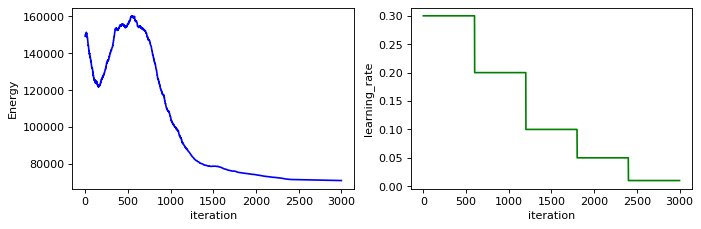

In [86]:

plt.figure(figsize = (10,3), dpi = 80)
plt.subplot(1,2,1)
plt.plot(np.arange(len(E)), E, 'b-')
plt.xlabel('iteration')
plt.ylabel('Energy')
#plt.title('Energy with iterations with n = '+str(n))

plt.subplot(1,2,2)
plt.plot(np.arange(len(E)), lrs, 'g-')
plt.xlabel('iteration')
plt.ylabel('learning_rate')
#plt.title('lrs with iterations with n = '+str(n))

#plt.savefig('./E_iteration_'+str(n), dpi=100)

In [95]:
def plot_geometry(points, G, mode, start = 0):
    fig, ax = plt.subplots()

    for i in points:
        x, y = i[0], i[1]
        ax.scatter(x, y, color = 'b', edgecolors='none', alpha = 0.9)

    for i in range(N):
        for j in range(i):
            if G[i][j] == 1:
                xtmp = [points[i][0], points[j][0]]
                ytmp = [points[i][1], points[j][1]]
                plt.plot(xtmp[0:2], ytmp[0:2],'g-', alpha = 0.01)
                #plt.savefig('./E_iteration_points_fini_n ='+str(n), dpi=150)
    ax.grid(True)
    if start == 1:
        plt.title('position initial')
    else:
        plt.title('position after SD, mode ='+str(mode))
    plt.show()

Then the obtained graph after gradient descent looks like below:

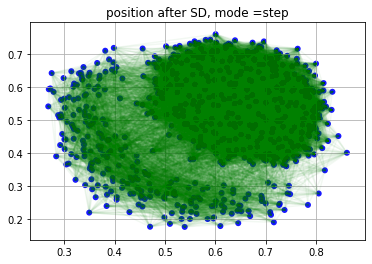

In [96]:
plot_geometry(gd_points, G, 'step')

While the following are initially generated graph:

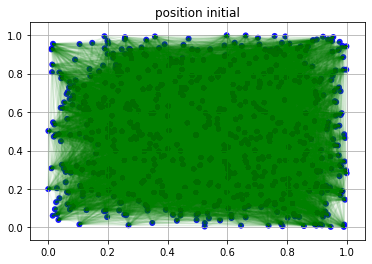

In [97]:
plot_geometry(points_origin, G, 'step', start = 1)

We then do the classification in using both spectral-clustering and k-means in python, testing in $k = 2,3,4,5$:

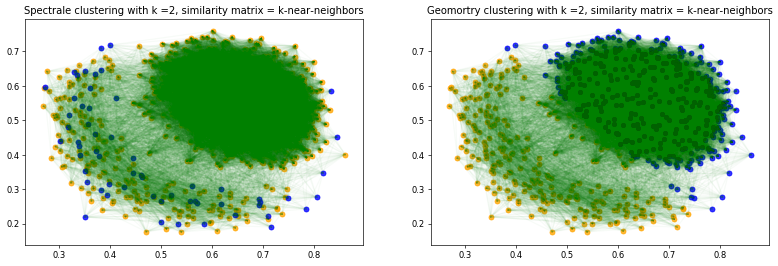

In [103]:
k = 2
group_spec = Spectual_kmeans(k, G)
X = gd_points.copy()
group_geo = KMeans(n_clusters = k, random_state=0).fit_predict(X)
plot_spectual_geometry_kmeans(gd_points, group_spec, group_geo)

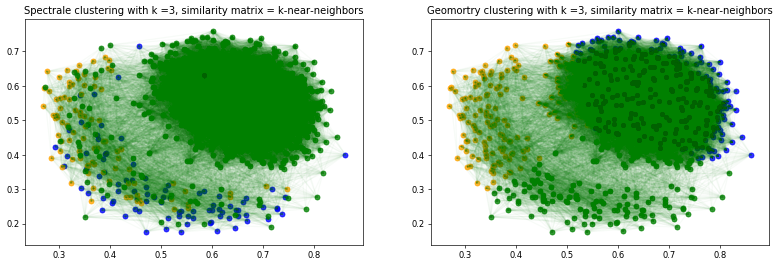

In [104]:
k = 3
group_spec = Spectual_kmeans(k, G)
X = gd_points.copy()
group_geo = KMeans(n_clusters = k, random_state=0).fit_predict(X)
plot_spectual_geometry_kmeans(gd_points, group_spec, group_geo)

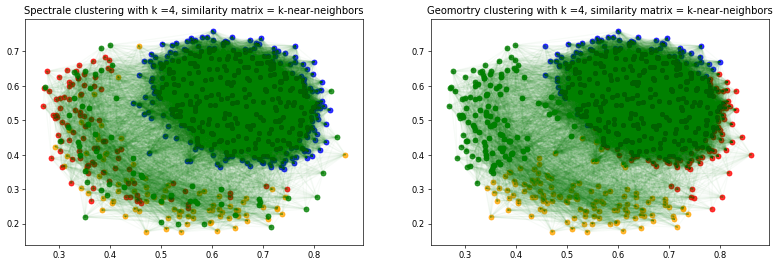

In [105]:
k = 4
group_spec = Spectual_kmeans(k, G)
X = gd_points.copy()
group_geo = KMeans(n_clusters = k, random_state=0).fit_predict(X)
plot_spectual_geometry_kmeans(gd_points, group_spec, group_geo)

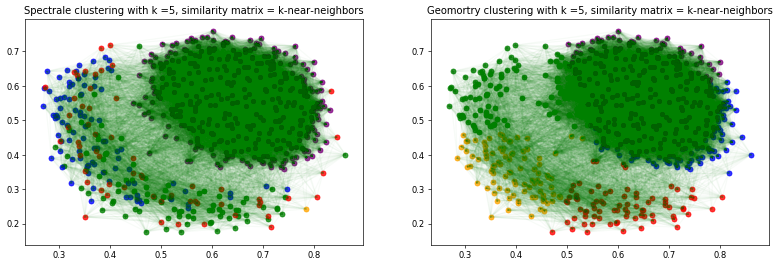

In [106]:
k = 5
group_spec = Spectual_kmeans(k, G)
X = gd_points.copy()
group_geo = KMeans(n_clusters = k, random_state=0).fit_predict(X)
plot_spectual_geometry_kmeans(gd_points, group_spec, group_geo)

We remark that the graph given by gradient descent is not yet optimal. Since from the graph given by using networkx, we see clearly that there are 4 cluster: a largest community with three smaller conmmunities affiliated to it. The three small communities are not distinguished from each other from the graph. 

However, in the case of $k=4$, we still see the difference by using k-means and spectral-clustering. Since spectral clustering leave the main community as a whole, while the k-means tries to divide the large community in two. So again, spectral-clustering reveil the structural information of the graph.

## 4 Popularity in a graph : proper value method (PageRank)

$\tilde{A}_{i,j}$ the normalized adjacent matrix:
$$\tilde{A}_{i,j} = \frac{A_{i,j}}{\sum_j A_{i,j}}$$

$P_{\epsilon} = (1-\epsilon)\tilde{A} + \frac{\epsilon}{n} B$, where $B\in \mathcal{M}_{n\times n}$ with all elments to be $1$. 

We remark that $\epsilon$ is the transition probability between $t = n$ et $t = n+1$. 

### Q4.1 
Discuss the role of ε.

The idea is to find a stationary state $u$ such that:
$$
u P = u
$$
This is transformed by find the eigenvector associated to 1 of :
$$
(P^T u^T)^T = (u^T)^T
$$

In [327]:
def Generate_direct_graphe(N):
    np.random.seed(seed)
    G = np.zeros((N,N))
    if N == 1:
        return np.array([[1]]) # if set 0 here, the 0 line will always be zero.
    if N == 2:
        return np.array([[0,0],[1,0]])
    
    #G = np.array([[1,1],[1,0]])
    G[0][0] = 1
    G[1][0] = 1
    for i in range(2,N):
        sortant = np.sum(G, axis = 0)
        entrant = np.sum(G, axis = 1)
        proba = (sortant + entrant)/(np.sum(sortant)+np.sum(entrant))
        proba_cum = np.cumsum(proba)
        rand = np.random.rand()
        #print(proba_cum)
        for j in range(1,len(proba_cum)):
            #flag = True # flag = true means add a self edge
            if rand <= proba_cum[0]:
                vertex = 0
                break
            else:
                if rand > proba_cum[j-1] and rand <= proba_cum[j]:
                    vertex = j
                    break
            #print('vertex = ', vertex)
        #print(vertex)
        G[i][vertex] = 1           

    return G

In [328]:
def cal_pscore(G, epsilon):
    n = len(G)
    #print('G = ', G)
    norm_coef = np.sum(G, axis = 1)
    A = G/norm_coef
    #print('A =', A)
    P = (1 - epsilon)*A + epsilon/n*np.ones((n,n))
    lambdas, uk = LA.eig(P.T)
    #print('lambdas = ', lambdas)
    #print('uk = \n', uk)
    pscore = uk[:,0]
         
    pscore = pscore/np.sum(pscore)
    #print('pscore = ', pscore)
    return pscore

A directed graph with 200 points drawing by nx.Digraph


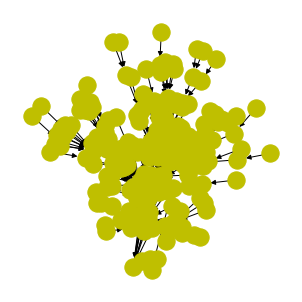

In [329]:
N = 200
G_4 = Generate_direct_graphe(N)
test = nx.DiGraph(G_4)
plt.figure(figsize=(4,4))
print('A directed graph with '+str(N)+' points drawing by nx.Digraph')
nx.draw(test,cmap = plt.get_cmap('jet'), node_color ='y')

We find that with $\epsilon$ increase, the distribution of pagerank score is more uniformly distributed. When $\epsilon = 0.05$, there is one point with a score about $0.9$, while when $\epsilon = 0.8$, then all points have similar scores. 
Thus, this way to evaluate the importance of the points is raisonable. 


When $N$ is large:

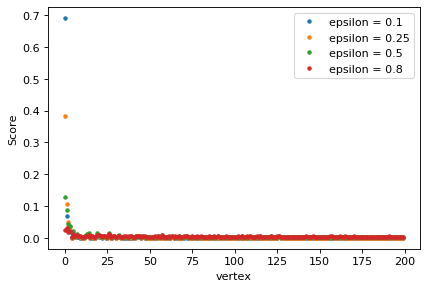

In [330]:
N = 200
epsilons = [0.1,0.25,0.5, 0.8]
pscores = []

plt.figure(figsize= (6,4), dpi = 80)
for epsilon in epsilons:
    G_4 = Generate_direct_graphe(N)
    test = nx.DiGraph(G_4)
    #print('oriented graph with '+str(N)+' vertex')
    #nx.draw(test, node_color = 'grey')
    pscore = cal_pscore(G_4, epsilon)
    plt.plot(np.arange(N), pscore, '.', label = 'epsilon = '+str(epsilon))
    #print('The normalized pagerank-score associated:', pscore)
plt.legend()
plt.xlabel('vertex')
plt.ylabel('Score')
plt.show()

However, from the graph above, I find this eigen-value method emphasize only the most important points. As we find in simulating small and large graph, on usually have one point have the score over $0.8$, while other points are nearly zero. So I am thinking of using the simulation way to verify the page rank score. Imagine that we have a random walk, who depart from a vertex, and go randomly to his neighbor vertex. We finally want to know the distribution of find the random walker in the graph. This scheme can be transformed by the situation below:
* We start by a graph of $N$ vertex, with transition matrix $P_{\epsilon}$. 
* We use a vector $v[N]$ to note the possibility of finding a random walker in the vertex $v_i$. 
* We start from a uniform distribution of all points, and we do $T$ iterations. Finally we look at the probability vector. Then we can find the points most important. 

In [331]:
def random_walker(G, T, num):
    n = len(G)
    P = (1 - epsilon)*G + epsilon/n*np.ones((n,n))
    k = T//num
    v = np.ones(n)/n
    V = []
    V.append(v)
    for i in range(1,T):
        vtmp = v.copy()
        #print('vtmp = ', vtmp)
        v = np.dot(v.T, P)
        #print('new v = ', v)
        if i%k == 0:
            V.append(v)
        if np.sum(v - vtmp) == 0:
            break
    return V

In [341]:
T = 20
num = 5
V = random_walker(G, T, num)

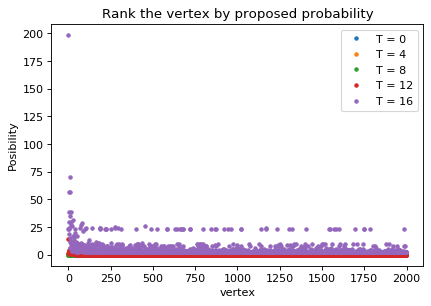

In [342]:
plt.figure(figsize= (6,4), dpi = 80)
for i in range(len(V)):
    plt.plot(np.arange(len(V[0])), V[i], '.', label = 'T = '+str(i*T//num))
plt.legend()
plt.xlabel('vertex')
plt.ylabel('Posibility')
plt.title('Rank the vertex by proposed probability')
plt.show()

### Q4.2

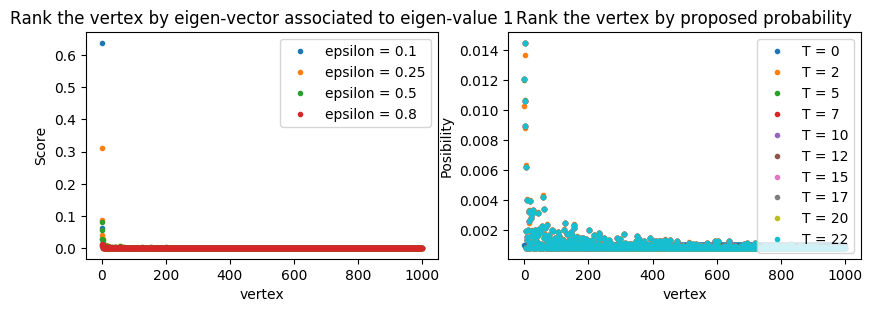

In [343]:
N = 1000
T = 50
num = 20
epsilons = [0.1,0.25,0.5, 0.8]
pscores = []
G_4 = Generate_direct_graphe(N)

plt.figure(figsize= (10,3), dpi = 100)
plt.subplot(1,2,1)
for epsilon in epsilons:
    test = nx.DiGraph(G_4)
    #print('oriented graph with '+str(N)+' vertex')
    #nx.draw(test, node_color = 'grey')
    pscore = cal_pscore(G_4, epsilon)
    plt.plot(np.arange(N), pscore, '.', label = 'epsilon = '+str(epsilon))
    #print('The normalized pagerank-score associated:', pscore)
plt.legend()
plt.xlabel('vertex')
plt.ylabel('Score')
plt.title('Rank the vertex by eigen-vector associated to eigen-value 1')


plt.subplot(1,2,2)
V = random_walker(G_4, T, num)

for i in range(len(V)):
    plt.plot(np.arange(len(V[0])), V[i], '.', label = 'T = '+str(i*T//num))
plt.legend()
plt.xlabel('vertex')
plt.ylabel('Posibility')
plt.title('Rank the vertex by proposed probability')


plt.show()

### Test whether we can "cheat" the Pagerank

We will test in a small graph. with only 10 points.

A directed graph with 10 points drawing by nx.Digraph


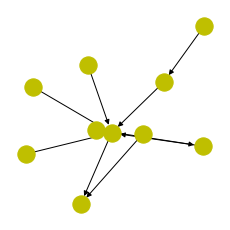

In [344]:
N = 10
G_4 = Generate_direct_graphe(N)
test = nx.DiGraph(G_4)
plt.figure(figsize=(3,3))
print('A directed graph with '+str(N)+' points drawing by nx.Digraph')
nx.draw(test,cmap = plt.get_cmap('jet'), node_color ='y')

In [345]:
print('Adjecency matrix: ', G_4)

Adjecency matrix:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In this graph, the vertex at the center is vertex 1, now we will manully add 5 vertex to point 9:

In [346]:
newG = np.zeros((15,15))
newG[:10,:10] = G_4
for i in range(5):
    newG[10+i][9] = 1
print('adjecency matrix of new graph:', newG)

adjecency matrix of new graph: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


A directed graph with 15 points drawing by nx.Digraph


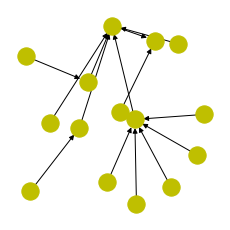

In [347]:
test = nx.DiGraph(newG)
plt.figure(figsize=(3,3))
print('A directed graph with '+str(N+5)+' points drawing by nx.Digraph')
nx.draw(test,cmap = plt.get_cmap('jet'), node_color ='y')

Now we will do the page rank for the two graph.

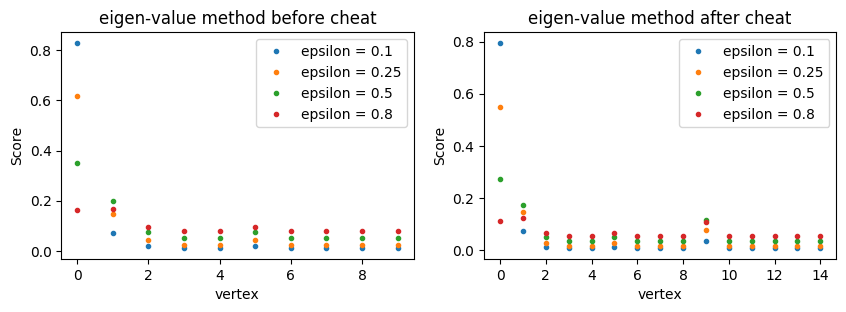

In [348]:
T = 20
num = 20
epsilons = [0.1,0.25,0.5, 0.8]
pscores = []
#G_4 = Generate_direct_graphe(N)

plt.figure(figsize= (10,3), dpi = 100)
plt.subplot(1,2,1)
for epsilon in epsilons:
    #print('oriented graph with '+str(N)+' vertex')
    #nx.draw(test, node_color = 'grey')
    pscore = cal_pscore(G_4, epsilon)
    plt.plot(np.arange(len(G_4)), pscore, '.', label = 'epsilon = '+str(epsilon))
    #print('The normalized pagerank-score associated:', pscore)
plt.legend()
plt.xlabel('vertex')
plt.ylabel('Score')
plt.title('eigen-value method before cheat')

epsilons = [0.1,0.25,0.5, 0.8]
plt.subplot(1,2,2)

for epsilon in epsilons:
    #print('oriented graph with '+str(N)+' vertex')
    #nx.draw(test, node_color = 'grey')
    pscore = cal_pscore(newG, epsilon)
    plt.plot(np.arange(len(newG)), pscore, '.', label = 'epsilon = '+str(epsilon))
    #print('The normalized pagerank-score associated:', pscore)
plt.legend()
plt.xlabel('vertex')
plt.ylabel('Score')
plt.title('eigen-value method after cheat')
plt.show()

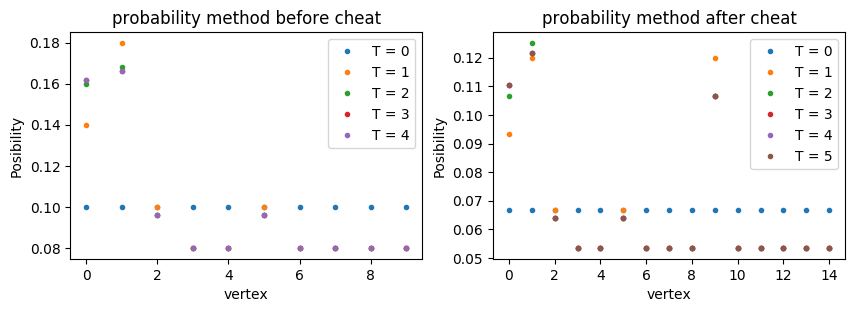

In [349]:
plt.figure(figsize= (10,3), dpi = 100)
plt.subplot(1,2,1)
V = random_walker(G_4, T, num)

for i in range(len(V)):
    plt.plot(np.arange(len(V[0])), V[i], '.', label = 'T = '+str(i*T//num))
plt.legend()
plt.xlabel('vertex')
plt.ylabel('Posibility')
plt.title('probability method before cheat')

plt.subplot(1,2,2)
V = random_walker(newG, T, num)

for i in range(len(V)):
    plt.plot(np.arange(len(V[0])), V[i], '.', label = 'T = '+str(i*T//num))
plt.legend()
plt.xlabel('vertex')
plt.ylabel('Posibility')
plt.title('probability method after cheat')


plt.show()

We find that in both method, we arrive at cheating the PageRank. While in the random walker simulation way it is more evident than the way using eigen-value 1.

### Note for coding part

One technical problem that I encountered and which I found annoying is that python 'linalg' package don't return eigen-values in a sorted way. It is discrete to find this problem, and as a result the spectral clustering don't works at the beginning. Maybe we can tell the student who take the course next year to evite this trap !